In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import multiprocessing
import math
import csv

Welcome to JupyROOT 6.24/06


In [2]:
def partition_helper(slice_entries, file_entries, file_curr, entry_curr):
    if slice_entries <= file_entries[file_curr] - entry_curr:
        return [file_curr, slice_entries + entry_curr]
    elif file_curr == len(file_entries) - 1:
        return [file_curr, file_entries[-1]]
    else:
        return partition_helper(slice_entries - file_entries[file_curr] + entry_curr, file_entries, file_curr + 1, 0)

def partition(files, n_processes):
    file_entries = [file.num_entries for file in files]
    slice_entries = math.ceil(sum(file_entries) / n_processes)
    slices = []
    file_start = 0
    entry_start = 0
    while not bool(slices) or slices[-1][-1] != (file_entries[-1]):
        slices.append([file_start, entry_start] + partition_helper(slice_entries, file_entries, file_start, entry_start))
        file_start = slices[-1][-2]
        entry_start = slices[-1][-1]
    return slices

def to_numpy_helper(files, partitions, index, result):
    data = []
    for i in range(partitions[index][0], partitions[index][2] + 1):
        data.append(files[i].arrays("candidate_vMass", 
                              "(candidate_charge == 0)\
                              & (candidate_cosAlpha > 0.99)\
                              & (candidate_lxy / candidate_lxyErr > 3.0)\
                              & (candidate_vProb > 0.05)\
                              & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                              & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                              entry_start=partitions[index][1] if i == partitions[index][0] else None,
                              entry_stop=partitions[index][3] if i == partitions[index][2] else None,
                              array_cache=None,
                              library="np")["candidate_vMass"])
    result.append(np.concatenate(tuple(data)))
    
def to_numpy(path, n_processes):
    start = time.time()
    files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))]
    partitions = partition(files, n_processes)
    result = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=to_numpy_helper, args=[files, partitions, i, result])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
        
    return np.concatenate(tuple(result))

In [3]:
path = "../data/64_files/"

In [4]:
# data = to_numpy(path, 64)

# file = uproot.recreate("tree/mass.root")
# file["CandidateTree"] = {"candidate_vMass" : data}

# data = uproot.open("tree/mass.root:CandidateTree").arrays(library="np")["candidate_vMass"]

# plt.figure(figsize=(15, 5))
# plt.hist(data, bins=200)
# plt.show()

In [5]:
file = ROOT.TFile("filtered_data/mass.root")
tree = file.Get("CandidateTree")
tree.Print()

******************************************************************************
*Tree    :CandidateTree:                                                        *
*Entries :   189667 : Total =         1518315 bytes  File  Size =     661942 *
*        :          : Tree compression factor =   2.30                       *
******************************************************************************
*Br    0 :candidate_vMass : candidate_vMass/D                                *
*Entries :   189667 : Total  Size=    1517960 bytes  File Size  =     661054 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   2.30     *
*............................................................................*


In [6]:
mass = ROOT.RooRealVar("candidate_vMass", "candidate_vMass", 5.33, 5.4)
data = ROOT.RooDataSet("data", "data", mass, ROOT.RooFit.Import(tree))
data.Print()


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

RooDataSet::data[candidate_vMass] = 189667 entries


In [7]:
c = ROOT.TCanvas("canvas", "canvas", 1500, 800)

In [8]:
mass_frame = mass.frame()
data.plotOn(mass_frame)
mass_frame.Draw()

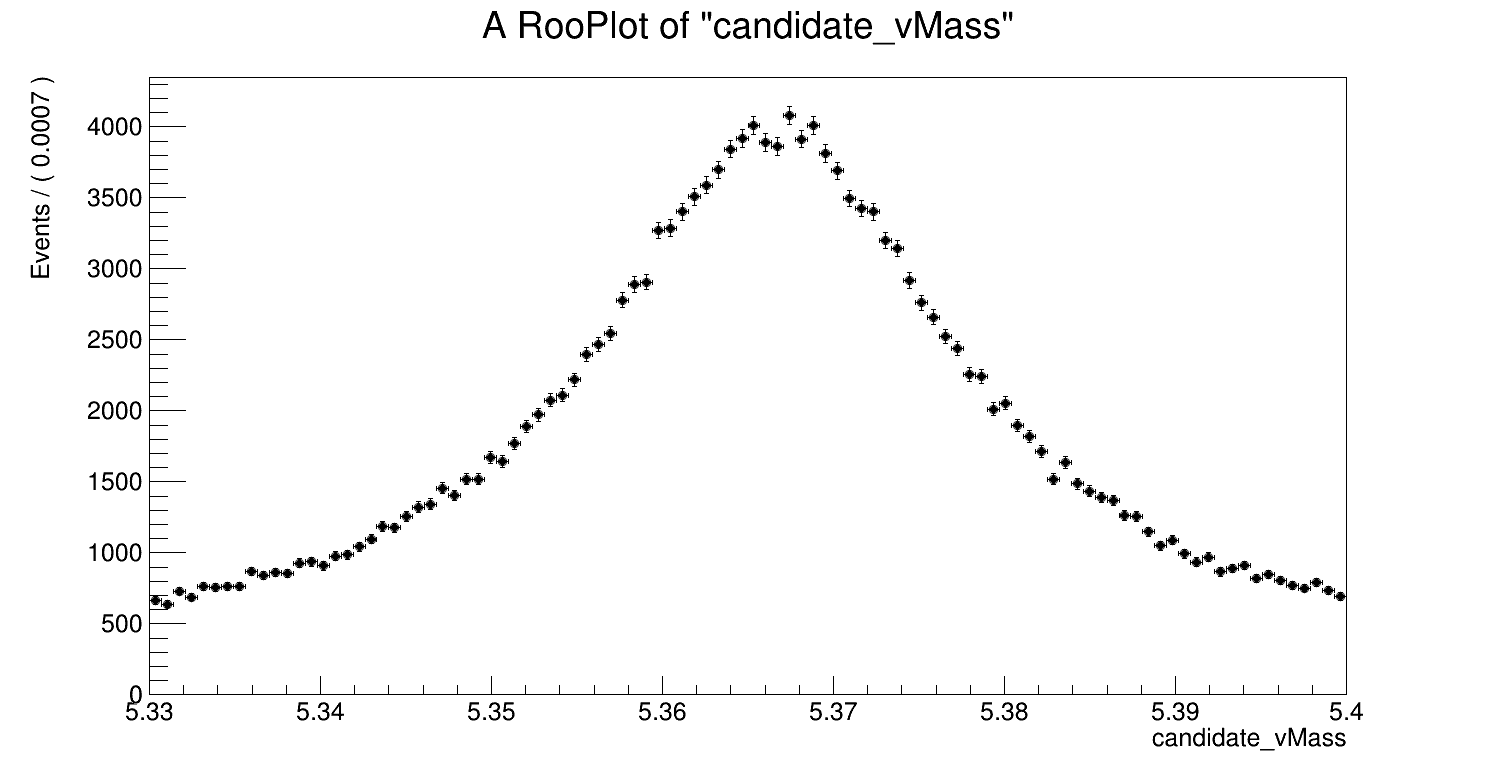

In [9]:
c.Draw()

In [10]:
mean = ROOT.RooRealVar("mean", "mean of gaussians", 5.37, 5.33, 5.4)
sigma = ROOT.RooRealVar("sigma", "width", 0.01, 0.001, 0.2)
signal = ROOT.RooGaussian("signal", "signal", mass, mean, sigma)

In [11]:
a0 = ROOT.RooRealVar("a0", "a0", 0.5, 0.0, 1.0)
a1 = ROOT.RooRealVar("a1", "a1", -0.3, -0.5, 1.0)
background = ROOT.RooChebychev("bkg", "Background", mass, ROOT.RooArgList(a0, a1))

In [12]:
bkgfrac = ROOT.RooRealVar("bkgfrac", "fraction of background", 0.5, 0.0, 1.0)
model = ROOT.RooAddPdf("model", "g+cheb", ROOT.RooArgList(background, signal), ROOT.RooArgList(bkgfrac))

In [13]:
r_full = model.fitTo(data, ROOT.RooFit.NumCPU(8))

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 8 remote server process.
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a0           5.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
     2 a1          -3.00000e-01  1.00000e-01   -5.00000e-01  1.00000e+00
     3 bkgfrac      5.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
     4 mean         5.37000e+00  7.00000e-03    5.33000e+00  5.40000e+00
     5 sigma        1.00000e-02  4.50000e-03    1.00000e-03  2.00000e-01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        2500           1

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (signal)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


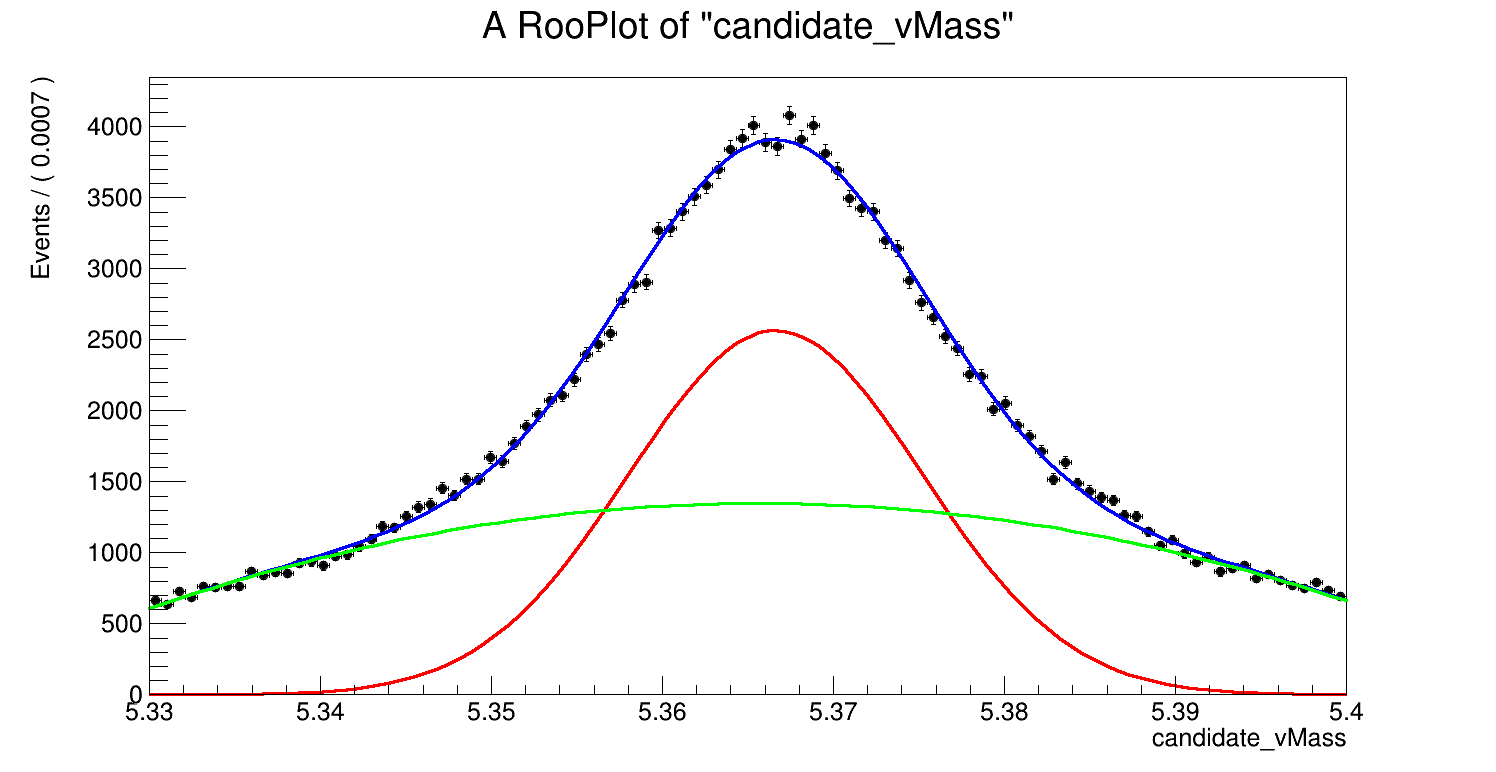

In [14]:
data.plotOn(mass_frame)
model.plotOn(mass_frame)

signal_component = ROOT.RooArgSet(signal)
background_component = ROOT.RooArgSet(background)

model.plotOn(mass_frame, ROOT.RooFit.Components(signal_component), ROOT.RooFit.LineColor(2));
model.plotOn(mass_frame, ROOT.RooFit.Components(background_component), ROOT.RooFit.LineColor(3));

mass_frame.Draw()
c.Draw()